# Importing Libraries

In [151]:
import librosa
from glob import glob
import numpy as np
from sklearn.mixture import GaussianMixture
import math
import os
import sys
sys.path.insert(0, r"C:\Users\Asus\Documents\GitHub\Speaker-Recoginition")
import adaptation

# Set paths

In [152]:
ubm_path = r'C:\Users\Asus\Documents\GitHub\Speaker_Verification\IITGMV\UBM_DATA\*\*'
base_path=r"C:\Users\Asus\Documents\GitHub\Speaker_Verification"
model_save_path=r"C:\Users\Asus\Documents\GitHub\Speaker_Verification\GMM_UBM_Models\\"
train_path= base_path + '\\' + 'Sample_train_data'
test_path=  base_path + '\\' + 'Sample_test_data'

In [153]:
cl_sz=64

In [154]:
train_files_1 = glob(train_path+"\*\*_AH01OENC.wav")
train_files_2 = glob(train_path+"\*\*_AH01MENC.wav")
train_files = train_files_1 + train_files_2
train_files.sort()
print(train_files)

['C:\\Users\\Asus\\Documents\\GitHub\\Speaker_Verification\\Sample_train_data\\1011\\1011_AH01OENC.wav', 'C:\\Users\\Asus\\Documents\\GitHub\\Speaker_Verification\\Sample_train_data\\1012\\1012_AH01OENC.wav', 'C:\\Users\\Asus\\Documents\\GitHub\\Speaker_Verification\\Sample_train_data\\1013\\1013_AH01OENC.wav', 'C:\\Users\\Asus\\Documents\\GitHub\\Speaker_Verification\\Sample_train_data\\1015\\1015_AH01OENC.wav', 'C:\\Users\\Asus\\Documents\\GitHub\\Speaker_Verification\\Sample_train_data\\1016\\1016_AH01OENC.wav']


In [155]:
test_files_1 = glob(test_path+"\*\*_AH01OENC_01*")
test_files_2 = glob(test_path+"\*\*_AH01MENC_02*")
test_files = test_files_1 + test_files_2
test_files.sort()

In [156]:
print(len(train_files))
print(len(test_files))

5
5


In [157]:
UBM = glob(ubm_path)

# Create UBM model

In [158]:
Feature =[]
for i in range(len(UBM)):
 audio_data, fs = librosa.load(UBM[i],sr=8000)

 audio_data=audio_data-np.mean(audio_data)
 audio_data=audio_data/(1.01*(max(abs(audio_data))))

 MFCC    = librosa.feature.mfcc(y=audio_data,sr=fs, n_mfcc=14, lifter=1,dct_type=3,hop_length=int(0.01*fs), win_length=int(0.02*fs),window='hann', n_mels=24)
 MFCC_d  = librosa.feature.delta(MFCC, order=1)
 MFCC_dd = librosa.feature.delta(MFCC, order=2)

 MFCC=MFCC.T
 MFCC_d=MFCC_d.T
 MFCC_dd=MFCC_dd.T

 MFCC=MFCC[:,1:14]
 MFCC_d=MFCC_d[:,1:14]
 MFCC_dd=MFCC_dd[:,1:14]

 X = np.concatenate((MFCC, MFCC_d), axis=1)
 X = np.concatenate((X, MFCC_dd), axis=1)

 for j in range(len(X)):
  feat = np.reshape(X[j],(1,39))
  Feature.append(feat)

 print('Training for UBM ',i,' completed')

Training for UBM  0  completed
Training for UBM  1  completed
Training for UBM  2  completed
Training for UBM  3  completed
Training for UBM  4  completed


In [159]:
Feature = np.reshape(Feature,(len(Feature),39))

In [160]:
UBM=GaussianMixture(n_components=cl_sz, random_state=0, max_iter=100,covariance_type='diag').fit(Feature)

# Create GMM models

In [161]:
SPK =[]
for i in range(len(train_files)):
 audio_data, fs = librosa.load(train_files[i],sr=8000)

 audio_data=audio_data-np.mean(audio_data)
 audio_data=audio_data/(1.01*(max(abs(audio_data))))

 MFCC    = librosa.feature.mfcc(y=audio_data,sr=fs, n_mfcc=14, lifter=1,dct_type=3,hop_length=int(0.01*fs), win_length=int(0.02*fs),window='hann', n_mels=24)
 MFCC_d  = librosa.feature.delta(MFCC, order=1)
 MFCC_dd = librosa.feature.delta(MFCC, order=2)

 MFCC=MFCC.T
 MFCC_d=MFCC_d.T
 MFCC_dd=MFCC_dd.T

 MFCC=MFCC[:,1:14]
 MFCC_d=MFCC_d[:,1:14]
 MFCC_dd=MFCC_dd[:,1:14]

 X = np.concatenate((MFCC, MFCC_d), axis=1)
 X = np.concatenate((X, MFCC_dd), axis=1)

 adapt=adaptation.SpeakerAdaptation()
 adapt  =  adapt.adapt_ubm(X.T,UBM,True)
 adapt_gmm  =  GaussianMixture(n_components=64,covariance_type='diag')
 adapt_gmm.means_ = adapt['means']
 adapt_gmm.weights_ = adapt['weights']
 adapt_gmm.covariances_ = adapt['covariances']
 adapt_gmm.precisions_ = adapt['precisions']
 adapt_gmm.precisions_cholesky_ = adapt['precisions_cholesky']
 SPK.append(adapt_gmm)
 print('Adapting for SPK ',i,' completed')

Adapting for SPK  0  completed
Adapting for SPK  1  completed
Adapting for SPK  2  completed
Adapting for SPK  3  completed
Adapting for SPK  4  completed


### Save Models

In [162]:
from sklearn import mixture

for i in range(len(train_files)):
 print(i)
 gmm_name = 'Speaker_'+str(i)
 np.save(model_save_path+gmm_name+'_weights', SPK[i].weights_, allow_pickle=False)
 np.save(model_save_path+gmm_name + '_means', SPK[i].means_, allow_pickle=False)
 np.save(model_save_path+gmm_name + '_covariances', SPK[i].covariances_, allow_pickle=False)
 np.save(model_save_path+gmm_name + '_precisions_cholesky', SPK[i].precisions_cholesky_, allow_pickle=False)
 

0
1
2
3
4


In [163]:
np.save(model_save_path+'UBM_weights', UBM.weights_, allow_pickle=False)
np.save(model_save_path+'UBM_means', UBM.means_, allow_pickle=False)
np.save(model_save_path+'UBM_covariances', UBM.covariances_, allow_pickle=False)
np.save(model_save_path+'UBM_precisions_cholesky', UBM.precisions_cholesky_, allow_pickle=False)

# Test the model

In [164]:
true = []
for i in range(len(test_files)):
  true.append(test_files[i].split('\\')[-2])
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
true = le.fit_transform(true)

In [165]:
Score = []
speaker=[]
pred = []
prob=[]
print(SPK)
for i in range(len(test_files)):
 audio_data, fs = librosa.load(test_files[i],sr=8000)

 audio_data=audio_data-np.mean(audio_data)
 audio_data=audio_data/(1.01*(max(abs(audio_data))))

 MFCC=librosa.feature.mfcc(y=audio_data,sr=fs, n_mfcc=14, lifter=1,dct_type=3,hop_length=int(0.01*fs), win_length=int(0.02*fs),window='hann', n_mels=24)
 MFCC_d  = librosa.feature.delta(MFCC, order=1)
 MFCC_dd = librosa.feature.delta(MFCC, order=2)

 MFCC=MFCC.T
 MFCC_d=MFCC_d.T
 MFCC_dd=MFCC_dd.T

 MFCC=MFCC[:,1:14]
 MFCC_d=MFCC_d[:,1:14]
 MFCC_dd=MFCC_dd[:,1:14]

 X = np.concatenate((MFCC, MFCC_d), axis=1)
 X = np.concatenate((X, MFCC_dd), axis=1)

 for j in range(len(SPK)):
  gmm_name = "Speaker_"+str(j)
  loaded_gmm = mixture.GaussianMixture(n_components = cl_sz, covariance_type='diag')
  means = np.load(model_save_path+gmm_name + '_means.npy')
  covar = np.load(model_save_path+gmm_name + '_covariances.npy')
  loaded_gmm.weights_ = np.load(model_save_path+gmm_name + '_weights.npy')
  loaded_gmm.precisions_cholesky_ = np.load(model_save_path+gmm_name + '_precisions_cholesky.npy')
  loaded_gmm.means_ = means
  loaded_gmm.covariances_ = covar
  log_likelihood_gmm = loaded_gmm.score(X)

  loaded_ubm = mixture.GaussianMixture(n_components = cl_sz, covariance_type='diag')
  means_ubm = np.load(model_save_path+'UBM_means.npy')
  covar_ubm = np.load(model_save_path+'UBM_covariances.npy')
  loaded_ubm.weights_ = np.load(model_save_path+'UBM_weights.npy')
  loaded_ubm.precisions_cholesky_ = np.load(model_save_path+'UBM_precisions_cholesky.npy')
  loaded_ubm.means_ = means
  loaded_ubm.covariances_ = covar
  log_likelihood_ubm = loaded_ubm.score(X)
 
  Score.append(log_likelihood_gmm - log_likelihood_ubm)
 pred_label = np.argmax(Score)
 if(pred_label == true[i]):
   pred.append(1)
 else:
   pred.append(0)  
 prob.append(abs(max(Score)))  
 speaker.append(pred_label)
 Score=[]
 print("Testing of Utterence "+str(i)+" completed")

[GaussianMixture(covariance_type='diag', n_components=64), GaussianMixture(covariance_type='diag', n_components=64), GaussianMixture(covariance_type='diag', n_components=64), GaussianMixture(covariance_type='diag', n_components=64), GaussianMixture(covariance_type='diag', n_components=64)]
[0.24292483415663924, -0.08813851651207472, -0.2022513646822901, -0.6353540775480013, -0.4191882660938546]
Testing of Utterence 0 completed
[-0.8617569263264357, 0.2937486310746209, -0.2562505614056647, -0.5207571626476835, -0.34469309515786506]
Testing of Utterence 1 completed
[-0.6923303536921921, -0.10546827704909845, 0.2654102022873417, -0.5130989119404745, -0.4321933046675852]
Testing of Utterence 2 completed
[-0.6470603151282717, 0.13799664273375356, 0.12031562000903762, 1.0115994586226833, 0.5070009012951431]
Testing of Utterence 3 completed
[-0.6230579532448672, -0.011937963877784341, -0.22181747913722916, -0.0022135148769990565, 0.45660701942394155]
Testing of Utterence 4 completed


In [166]:
len(SPK)

5

In [167]:
Score = []
for i in range(len(test_files)):
 print(i)
 audio_data, fs = librosa.load(test_files[i],sr=8000)

 audio_data=audio_data-np.mean(audio_data)
 audio_data=audio_data/(1.01*(max(abs(audio_data))))

 MFCC=librosa.feature.mfcc(y=audio_data,sr=fs, n_mfcc=14, lifter=1,dct_type=3,hop_length=int(0.01*fs), win_length=int(0.02*fs),window='hann', n_mels=24)
 MFCC_d  = librosa.feature.delta(MFCC, order=1)
 MFCC_dd = librosa.feature.delta(MFCC, order=2)

 MFCC=MFCC.T
 MFCC_d=MFCC_d.T
 MFCC_dd=MFCC_dd.T

 MFCC=MFCC[:,1:14]
 MFCC_d=MFCC_d[:,1:14]
 MFCC_dd=MFCC_dd[:,1:14]

 X = np.concatenate((MFCC, MFCC_d), axis=1)
 X = np.concatenate((X, MFCC_dd), axis=1)

 for j in range(len(SPK)):
  gmm_spk=SPK[j]
  log_likelihood_gmm = gmm_spk.score(X)
  log_likelihood_ubm = UBM.score(X)
  Score.append(log_likelihood_gmm-log_likelihood_ubm)
  # print(len(Score))
Score = np.reshape(Score,(len(test_files),len(SPK)))  

0
1
2
3
4


In [168]:
speaker=[]
for i in range(len(Score)):
  speaker.append(np.argmax(Score[i]))

In [169]:
print(test_files[0].split('\\')[-2])


1011


In [170]:
true = []
for i in range(len(test_files)):
  true.append(test_files[i].split('\\')[-2])
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
true = le.fit_transform(true)

In [171]:
from sklearn.metrics import accuracy_score
accuracy_score(true, speaker)

1.0

In [172]:
from sklearn.metrics import accuracy_score
accuracy_score(true, speaker)

1.0

In [173]:
from sklearn.metrics import confusion_matrix
CM = confusion_matrix(true, speaker)
print(CM)

[[1 0 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]]


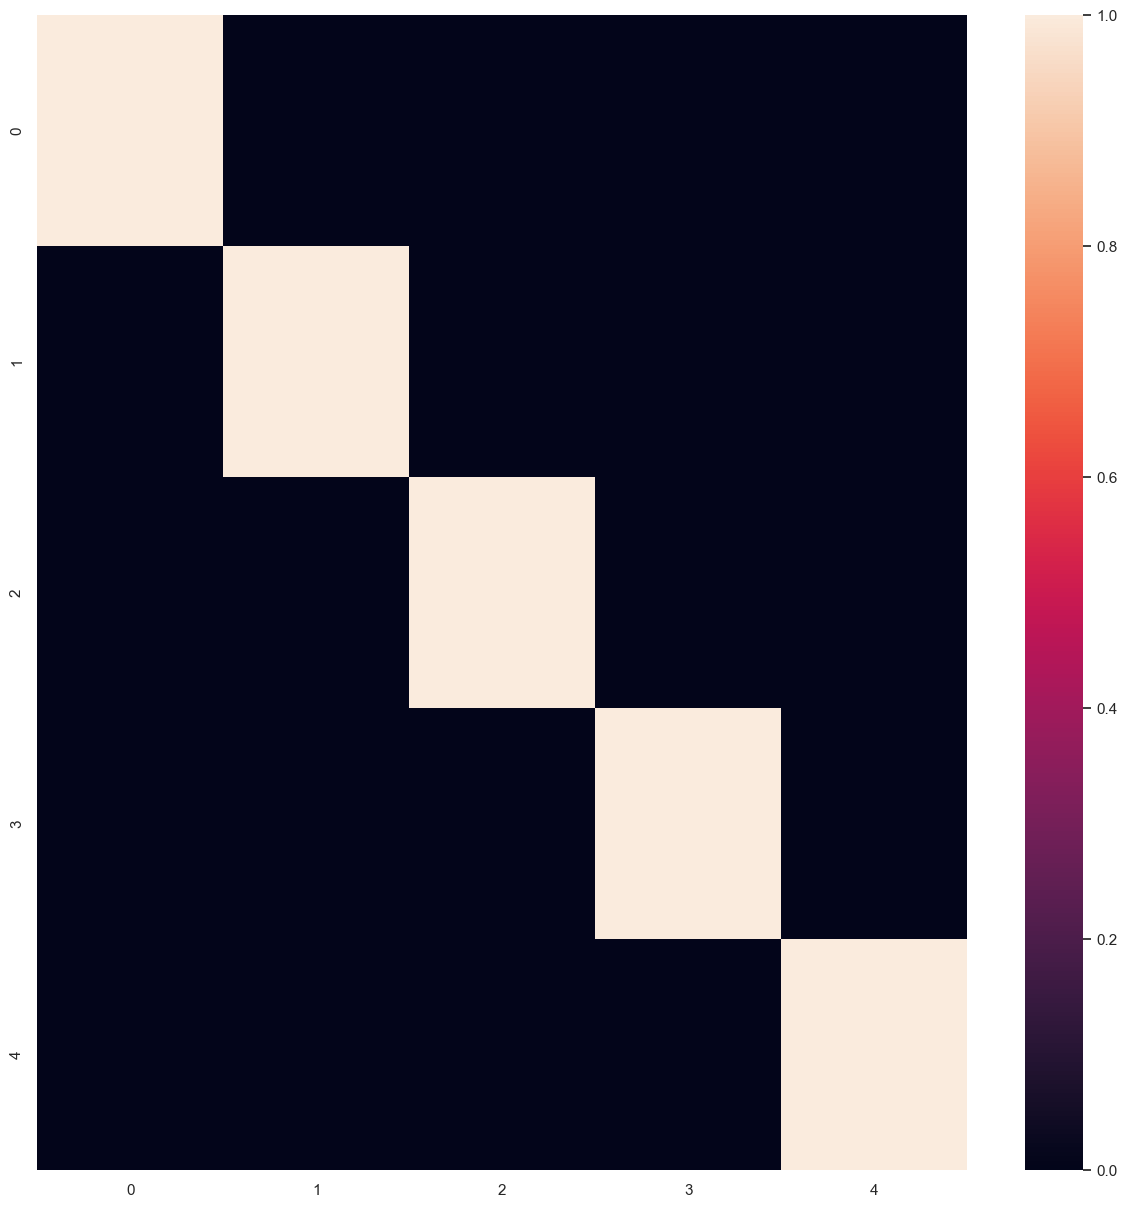

In [174]:
import seaborn as sn
import matplotlib.pyplot as plt
sn.set(rc = {'figure.figsize':(15,15)})
hm = sn.heatmap(data =CM)
plt.show()